## Exp4 analysis of MS1 IT influence on low pg (<120pg) quantification 
**DIA-NN output**

In [1]:
#Importing packages 
import pandas as pd 
import numpy as np
import os 
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import mstats
import dask.dataframe as dd
sns.set_style("ticks")

myColors = ["#7400b8","#6930c3","#5e60ce","#5390d9","#4ea8de","#48bfe3","#56cfe1","#64dfdf","#72efdd","#80ffdb"]

/Users/valdemaras/Programs/miniconda/miniconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#Data 
df = pd.read_csv("data/Exp4/wishDIA_lowpg_noInf.tsv",sep = "\t", decimal=',') 
#Extracting the required information from the file name
df['Load'] =  df.iloc[:,0].str.extract(r'20w_(.*?)_')[0].values
df['Replicate'] =  df['R.FileName'].str.extract(r'pg_(.)$') 
df = df.replace(0, np.nan)
df

,R.FileName,PG.ProteinGroups,PG.Quantity,PEP.GroupingKey,PEP.MS1Quantity,PEP.MS2Quantity,PEP.UsedForProteinGroupQuantity,EG.PrecursorId,EG.Qvalue,EG.DatapointsPerPeak (MS1),EG.DatapointsPerPeak,EG.FWHM,EG.MeanApexRT,EG.PeakWidth,EG.SignalToNoise,EG.TotalQuantity (Settings),EG.Noise,Load,Replicate
0,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,A0A0B4J2D5;P0DPI2,28.313456,NLSTFAVDGK,29.875563,4.188894,True,_NLSTFAVDGK_.2,8.963295e-04,7,3.0,0.041782,10.342094,0.101946,4.344594,29.875563,27.811142,10pg,1
1,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,A0A0B4J2D5;P0DPI2,28.313456,EVVEAHVDQK,28.590612,2.074916,True,_EVVEAHVDQK_.2,2.354340e-03,6,3.0,0.033184,3.339525,0.087900,3.324823,28.590612,11.795326,10pg,1
2,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,A0MZ66,NaN,LVEVIEEVNK,0.479897,4.540475,True,_LVEVIEEVNK_.2,9.712538e-03,5,2.0,0.042599,12.537769,0.075967,3.581873,0.479897,37.150627,10pg,1
3,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,A6NGJ6;A6NI03;A6NLI5,14.977170,HLQALER,14.977170,2.840787,True,_HLQALER_.2,2.358461e-03,6,2.0,0.052789,3.552791,0.083065,2.252518,14.977170,28.931847,10pg,1
4,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,A6NMZ7;A6NMZ7-2,111.093918,VDCEIDK,111.093918,7.248876,True,_VDC[Carbamidomethyl (C)]EIDK_.2,7.118712e-04,4,1.0,0.044956,3.055370,0.054155,9.823334,111.093918,23.783386,10pg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254193,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,Q9Y6N5,365.525269,VGAENVAIVEPSER,217.584351,30.767696,True,_VGAENVAIVEPSER_.2,2.045549e-10,5,2.0,0.076950,10.198601,0.080502,16.388920,217.584351,36.079296,100pg,3
254194,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,Q9Y6N5,365.525269,VTELNPDK,261.877716,46.211029,False,_VTELNPDK_.2,7.007649e-07,8,4.0,0.069346,3.896806,0.114374,5.703114,261.877716,122.235107,100pg,3
254195,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,Q9Y6N5,365.525269,IMYLSEAYFR,23.108864,20.669300,False,_IMYLSEAYFR_.2,5.496562e-06,6,3.0,0.069369,15.946723,0.068818,10.431211,23.108864,48.982273,100pg,3
254196,20240314_OM_VP_Vanquish_uPAC_trapElute_22min_D...,Q9Y6Y8,55.805859,RIDYVLQEK,115.701782,14.573450,True,_RIDYVLQEK_.2,9.955274e-08,3,1.0,0.057557,8.413625,0.055512,1.803288,115.701782,44.440868,100pg,3


In [3]:
df = df.loc[df['EG.Qvalue'] < 0.001,:]
df.Load.value_counts()

#temp = df.loc[df['Load'] == '10pg',:]

peptide_count = df.value_counts('PEP.GroupingKey')

good_peptides = peptide_count[peptide_count == 18]

df2= df.loc[df['PEP.GroupingKey'].isin(good_peptides.index),:]
len(good_peptides)

1064

#### Evaluating CVs

In [4]:
#Calculate the CVs for each condition

cv_ms1 = df2.groupby(['Load','PEP.GroupingKey'])['PEP.MS1Quantity'].apply(lambda x: np.std(x)/np.mean(x)).reset_index()
cv_ms2 = df2.groupby(['Load','PEP.GroupingKey'])['PEP.MS2Quantity'].apply(lambda x: np.std(x)/np.mean(x)).reset_index()

cv_ms1.columns = ['Load', 'PEP.GroupingKey', 'PEP.Quantity']
cv_ms2.columns = ['Load', 'PEP.GroupingKey', 'PEP.Quantity']
cv_ms1['Level'] = 'MS1'
cv_ms2['Level'] = 'MS2'
cv_ms = pd.concat([cv_ms1, cv_ms2], axis =0)

ValueError: Could not interpret input 'PEP.MS1Quantity'

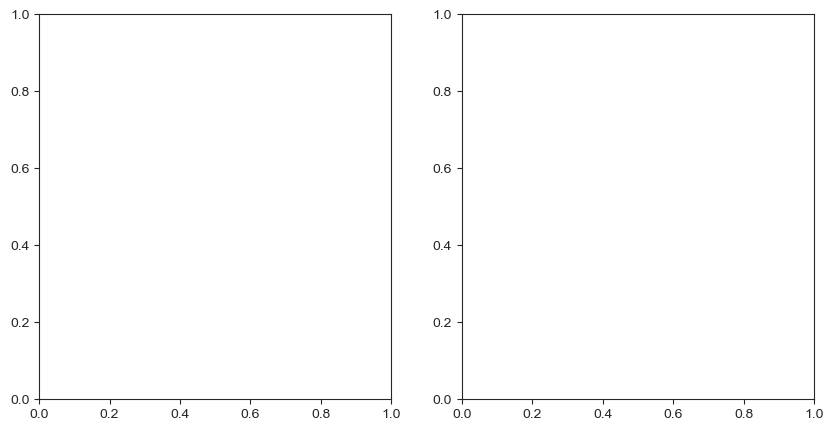

In [5]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
sns.violinplot(data = cv_ms1, x = 'Load', y = 'PEP.MS1Quantity',  palette = 'viridis', order = ['100pg', '50pg', '40pg', '30pg', '20pg', '10pg'], ax = axes[0])
sns.violinplot(data = cv_ms2, x = 'Load', y = 'PEP.MS2Quantity',  palette = 'cividis', order = ['100pg', '50pg', '40pg', '30pg', '20pg', '10pg'], ax = axes[1])

In [ ]:
mean_ms1 = df2.groupby(['Load','PEP.GroupingKey'])['PEP.MS1Quantity'].apply(lambda x: np.log2(np.mean(x))).reset_index()
mean_ms2 = df2.groupby(['Load','PEP.GroupingKey'])['PEP.MS2Quantity'].apply(lambda x: np.log2(np.mean(x))).reset_index()

mean_ms1.columns = ['Load', 'PEP.GroupingKey', 'PEP.Quantity']
mean_ms2.columns = ['Load', 'PEP.GroupingKey', 'PEP.Quantity']
mean_ms1['Level'] = 'MS1'
mean_ms2['Level'] = 'MS2'
mean_ms = pd.concat([mean_ms1, mean_ms2], axis =0)
mean_ms

,Load,PEP.GroupingKey,PEP.Quantity,Level
0,100pg,AAAAAAALQAK,13.290772,MS1
1,100pg,AAAFEQLQK,10.222129,MS1
2,100pg,AAAMANNLQK,10.201399,MS1
3,100pg,AADLNGDLTATR,11.423033,MS1
4,100pg,AADTIGYPVMIR,11.289198,MS1
...,...,...,...,...
6354,50pg,YSLEPVAVELK,9.536034,MS2
6355,50pg,YSPDVLK,4.152988,MS2
6356,50pg,YSTSGSSGLTTGK,4.758400,MS2
6357,50pg,YVECSALTQK,6.130790,MS2


In [ ]:
mean_ms1

,Load,PEP.GroupingKey,PEP.Quantity,Level
0,100pg,AAAAAAALQAK,13.290772,MS1
1,100pg,AAAFEQLQK,10.222129,MS1
2,100pg,AAAMANNLQK,10.201399,MS1
3,100pg,AADLNGDLTATR,11.423033,MS1
4,100pg,AADTIGYPVMIR,11.289198,MS1
...,...,...,...,...
6354,50pg,YSLEPVAVELK,12.976661,MS1
6355,50pg,YSPDVLK,7.304442,MS1
6356,50pg,YSTSGSSGLTTGK,8.656191,MS1
6357,50pg,YVECSALTQK,9.472055,MS1


<AxesSubplot:xlabel='Load', ylabel='PEP.Quantity'>

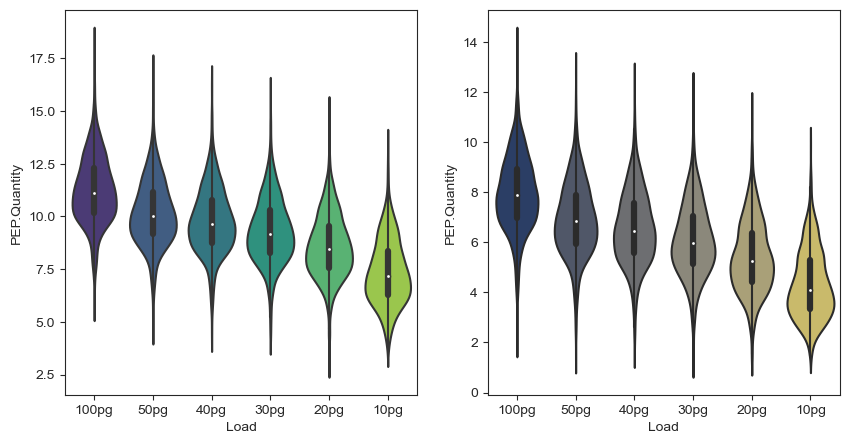

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
sns.violinplot(data = mean_ms1, x = 'Load', y = 'PEP.Quantity',  palette = 'viridis', order = ['100pg', '50pg', '40pg', '30pg', '20pg', '10pg'], ax = axes[0])
sns.violinplot(data = mean_ms2, x = 'Load', y = 'PEP.Quantity',  palette = 'cividis', order = ['100pg', '50pg', '40pg', '30pg', '20pg', '10pg'], ax = axes[1])

<AxesSubplot:xlabel='er_10_20', ylabel='Count'>

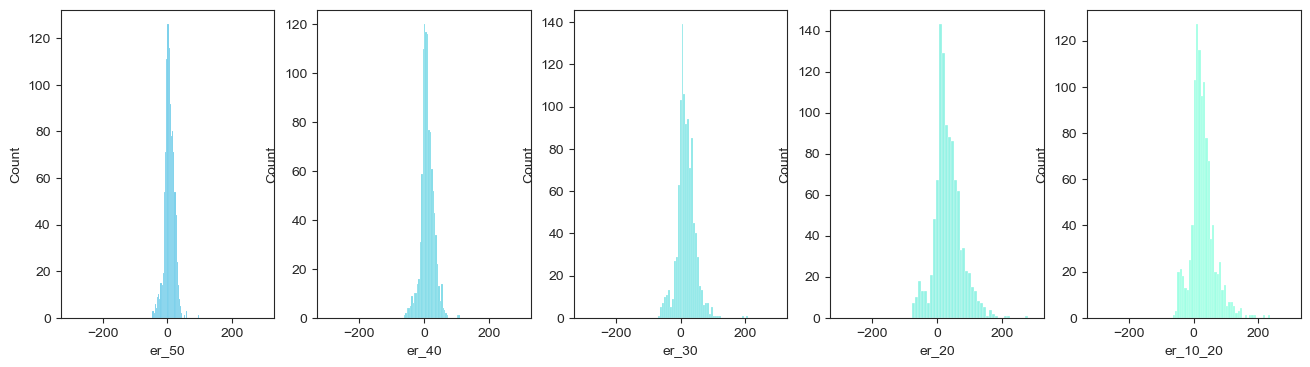

In [ ]:
quant_ms1 = df2.pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index().dropna()

#Making everything relative to 50pg

#Everything relative to 50pg
quant_ms1['er_50'] = (50/100 - (quant_ms1['50pg']/quant_ms1['100pg']))/(quant_ms1['50pg']/quant_ms1['100pg']) * 100
quant_ms1['er_40'] = (40/100 - (quant_ms1['40pg']/quant_ms1['100pg']))/(quant_ms1['40pg']/quant_ms1['100pg']) * 100
quant_ms1['er_30'] = (30/100 - (quant_ms1['30pg']/quant_ms1['100pg']))/(quant_ms1['30pg']/quant_ms1['100pg']) * 100
quant_ms1['er_20'] = (20/100 - (quant_ms1['20pg']/quant_ms1['100pg']))/(quant_ms1['20pg']/quant_ms1['100pg']) * 100
quant_ms1['er_10'] = (10/100 - (quant_ms1['10pg']/quant_ms1['100pg']))/(quant_ms1['10pg']/quant_ms1['100pg']) * 100
quant_ms1['er_10_20'] = (10/20 - (quant_ms1['10pg']/quant_ms1['20pg']))/(quant_ms1['10pg']/quant_ms1['20pg']) * 100


fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = quant_ms1, x = 'er_50', color = myColors[5], ax =axes[0], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_40', color = myColors[6], ax =axes[1], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_30', color = myColors[7], ax =axes[2], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_20', color = myColors[8], ax =axes[3], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_10_20', color = myColors[9], ax =axes[4], binrange=(-300,300))

<AxesSubplot:xlabel='er_10_20', ylabel='Count'>

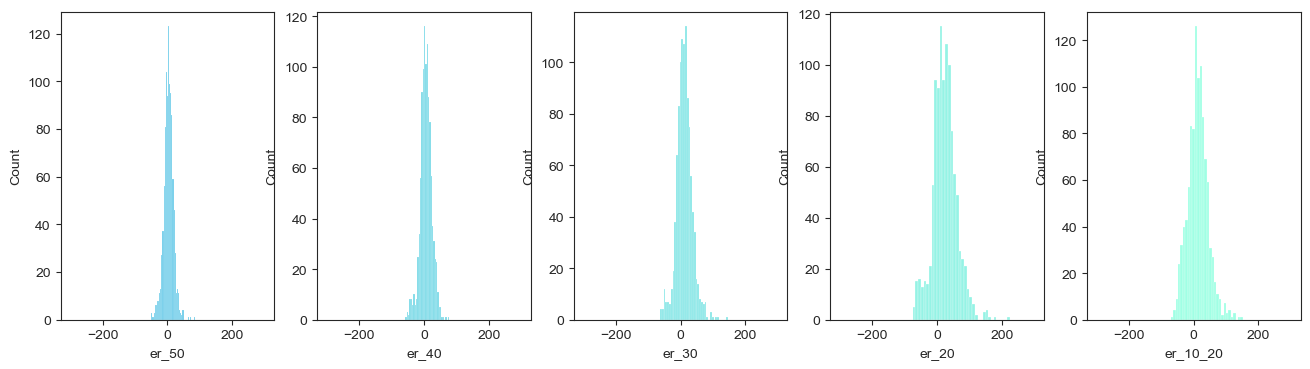

In [ ]:
quant_ms2 = df2.pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index().dropna()

#Making everything relative to 50pg

#Everything relative to 50pg
quant_ms2['er_50'] = (50/100 - (quant_ms2['50pg']/quant_ms2['100pg']))/(quant_ms2['50pg']/quant_ms2['100pg']) * 100
quant_ms2['er_40'] = (40/100 - (quant_ms2['40pg']/quant_ms2['100pg']))/(quant_ms2['40pg']/quant_ms2['100pg']) * 100
quant_ms2['er_30'] = (30/100 - (quant_ms2['30pg']/quant_ms2['100pg']))/(quant_ms2['30pg']/quant_ms2['100pg']) * 100
quant_ms2['er_20'] = (20/100 - (quant_ms2['20pg']/quant_ms2['100pg']))/(quant_ms2['20pg']/quant_ms2['100pg']) * 100
quant_ms2['er_10'] = (10/100 - (quant_ms2['10pg']/quant_ms2['100pg']))/(quant_ms2['10pg']/quant_ms2['100pg']) * 100
quant_ms2['er_10_20'] = (10/20 - (quant_ms2['10pg']/quant_ms2['20pg']))/(quant_ms2['10pg']/quant_ms2['20pg']) * 100


fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = quant_ms2, x = 'er_50', color = myColors[5], ax =axes[0], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_40', color = myColors[6], ax =axes[1], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_30', color = myColors[7], ax =axes[2], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_20', color = myColors[8], ax =axes[3], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_10_20', color = myColors[9], ax =axes[4], binrange=(-300,300))

In [ ]:
quant_ms1_rep1 = df2.loc[df.Replicate == '1',:].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index().dropna()
quant_ms1_rep2 = df2.loc[df.Replicate == '2',:].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index().dropna()
quant_ms1_rep3 = df2.loc[df.Replicate == '3',:].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index().dropna()

#Mark the replicate number 

quant_ms1_rep1['Replicate'] = '1'
quant_ms1_rep2['Replicate'] = '2'
quant_ms1_rep3['Replicate'] = '3'

quant_ms1_rep = pd.concat([quant_ms1_rep1, quant_ms1_rep2, quant_ms1_rep3])

#Remove peptides that are not found in all three replicates 

good_peptides = quant_ms1_rep.value_counts('PEP.GroupingKey')

quant_ms1_rep = quant_ms1_rep.loc[quant_ms1_rep['PEP.GroupingKey'].isin(good_peptides[good_peptides == 3].index),:]


#Everything relative to 50pg
quant_ms1_rep['er_50'] = (50/100 - (quant_ms1_rep['50pg']/quant_ms1_rep['100pg']))/(quant_ms1_rep['50pg']/quant_ms1_rep['100pg']) * 100
quant_ms1_rep['er_40'] = (40/100 - (quant_ms1_rep['40pg']/quant_ms1_rep['100pg']))/(quant_ms1_rep['40pg']/quant_ms1_rep['100pg']) * 100
quant_ms1_rep['er_30'] = (30/100 - (quant_ms1_rep['30pg']/quant_ms1_rep['100pg']))/(quant_ms1_rep['30pg']/quant_ms1_rep['100pg']) * 100
quant_ms1_rep['er_20'] = (20/100 - (quant_ms1_rep['20pg']/quant_ms1_rep['100pg']))/(quant_ms1_rep['20pg']/quant_ms1_rep['100pg']) * 100
quant_ms1_rep['er_10'] = (10/100 - (quant_ms1_rep['10pg']/quant_ms1_rep['100pg']))/(quant_ms1_rep['10pg']/quant_ms1_rep['100pg']) * 100
quant_ms1_rep['er_10_20'] = (10/20 - (quant_ms1_rep['10pg']/quant_ms1_rep['20pg']))/(quant_ms1_rep['10pg']/quant_ms1_rep['20pg']) * 100
quant_ms1_rep['er_20_40'] = (20/40 - (quant_ms1_rep['20pg']/quant_ms1_rep['40pg']))/(quant_ms1_rep['20pg']/quant_ms1_rep['40pg']) * 100


quant_ms1_rep1['PEP.GroupingKey'].isin(quant_ms1_rep3['PEP.GroupingKey']).sum()

quant_ms1_rep

Load,PEP.GroupingKey,100pg,10pg,20pg,30pg,40pg,50pg,Replicate,er_50,er_40,er_30,er_20,er_10,er_10_20,er_20_40
0,AAAAAAALQAK,9512.196289,920.497925,1855.022705,2860.827637,3968.805664,4914.604004,1,-3.225201,-4.130390,-0.250583,2.556117,3.337509,0.761917,6.974585
1,AAAFEQLQK,1163.439209,62.358398,198.683655,325.478210,407.809204,581.080078,1,0.110058,14.116032,7.236599,17.114738,86.572978,59.307856,2.627769
2,AAAMANNLQK,1148.743530,102.079338,219.951553,375.940002,474.800354,595.426270,1,-3.536039,-3.223027,-8.330304,4.454232,12.534383,7.735590,7.932940
3,AADLNGDLTATR,2826.092529,191.853058,425.319275,777.243286,968.474854,1233.234985,1,14.580456,16.723424,9.081387,32.892756,47.305055,10.845060,13.852688
4,AADTIGYPVMIR,2636.730225,73.739899,238.990845,453.886627,557.538391,962.199829,1,37.015729,89.169411,74.276795,120.655333,257.571718,62.049887,16.644299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,YSLEPVAVELK,20657.462891,514.232300,1701.442261,3491.388184,6072.755371,8069.315918,3,28.000088,36.066491,77.500712,142.822967,301.714612,65.435180,78.459049
1060,YSPDVLK,315.435913,25.878225,55.029968,114.698265,128.486954,161.716782,3,-2.472734,-1.799863,-17.495898,14.641503,21.892405,6.324849,16.742711
1061,YSTSGSSGLTTGK,720.746704,82.921417,142.832993,216.287903,330.225159,408.877075,3,-11.862666,-12.696330,-0.029540,0.921600,-13.080754,-13.874487,15.598348
1062,YVECSALTQK,1472.699219,78.535095,296.827240,394.085938,551.043213,810.359131,3,-9.132929,6.902630,12.110005,-0.770615,87.521160,88.977450,-7.177789


In [ ]:
#Exporting data 

cv_ms.to_csv("data/Exp4/output/cv_ms.txt", sep = "\t", index = False)
mean_ms.to_csv("data/Exp4/output/mean_ms.txt", sep = "\t", index = False)
quant_ms1_rep.to_csv("data/Exp4/output/quant_ms1_rep.txt", sep = "\t", index = False)